In [168]:
%pylab inline
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
import sklearn.metrics as metrics
import sklearn.datasets as datasets

import torch as th
import torch.nn as nn
import torch.optim as optim

import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


In this notebook, we will look at a classification problem that is not lineraly separable, show that a linear model is insufficient to solve it, and then build a simple neural network architecture that is capable of performing sufficiently on the data

In [2]:
X = []
y = []

with open('X.npy', 'rb') as fp:
    X = np.load(fp)
with open('y.npy', 'rb') as fp:
    y = np.load(fp)

Now let us plot the data to see if it is linearly separable or not

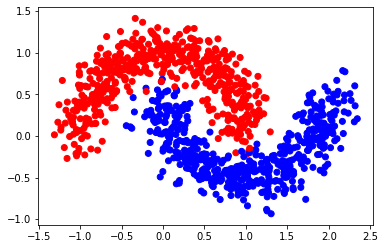

In [3]:
X, y = datasets.make_moons(n_samples=1000, noise=0.15, shuffle=True)
colors = np.array(['red' if cl == 0 else 'blue' for cl in y])
plt.scatter(X[:,0], X[:,1],c=colors)

As can be seen, any line that we try to use to separate our two classes would fail to perform well. Let us see that in quantitative terms by training a logistic regression instance to try and solve this problem

In [7]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1s.append(metrics.f1_score(y_test, predictions))

print('Mean F1 score is ', np.mean(f1s), ' with a std. dev of ', np.std(f1s))


Mean F1 score is  0.8575280412340932  with a std. dev of  0.030554875395517413


This score is less than ideal, let us try a neural network architecture to try and solve it! Since there is an "imaginary" curve that we can use to split the two classes, a continous curve, we should start with a network with one hidden layer. However, we need to make some decisions on the number of weights in the layer and what activation function to use!

Let is consider the following archiecture diagram just to get some terms out of the way. Consider the following image
![A Simple Architecture](NN1.png)

Nodes 1 and 2 recieve input and nodes 3 and 4 receive a linear transformation of those inputs. The weights $w_{13}, w_{14}, w_{23}, \text{ and } w_{24}$ collectively comprise the hidden layer! Moreover, since this layer performs a linear transformation, we call this a linear layer. The layer accepts 2 inputs (as a vector) and returns 2 outputs (as a single vector); we have a $2 \times 2$ linear layer

Following this hidden layer's transformations, we pass the resultant output through the activation function (we shall look at several examples)

Afterwards, we have another linear layer (a $2 \times 1$) followed by another activation function. Since we have treating this as a binary classicaton problem, $g_3$ should be sigmoid. Essentially the hidden portion of the network transform the original data into a form that another portion that is essentially linear can solve. 

A network such as this is too simple to solve the half moon problem, but the terminology stands.

Note that neural networks are low bias-high variance models; hence they are prone to overfitting. Regularization is a good strategy to prevent overfitting.

In [153]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()
        
    def forward(self, X):
        return None 
    
    def loss(self, X, y):
        probs = self.forward(X)
        return self.loss_func(probs, y)
    
    def predict_proba(self, X, as_numpy=False):
        res = self.forward(X)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, X, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(X, as_numpy)
        return probs > threshold
    
    def fit(self, X, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(X, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [154]:
class NNModel1(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 2, bias=True)
        self.act1 = nn.Sigmoid()
        self.l2 = nn.Linear(2, 1, bias=True)
        self.act2 = nn.Sigmoid()
        
    
    def forward(self, X):
        res = self.l1(X)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res
    
    

In [155]:
class NNModel2(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 5, bias=True)
        self.act1 = nn.PReLU() # special version of Leaky ReLU where scale parameter is learnt
        self.l2 = nn.Linear(5, 2, bias=True)
        self.act2 = nn.PReLU() # special version of Leaky ReLU where scale parameter is learnt
        self.l3 = nn.Linear(2, 1, bias=True)
        self.act3 = nn.Sigmoid()
    
    def get_intermediary(self, X):
        res = self.l1(X)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res
    
    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res


Now, let us apply kFold again

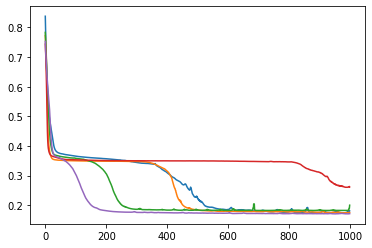

In [160]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

f1_lr = []
f1_nn1 = []
f1_nn2 = []

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    nn1 = NNModel1()
    curve = nn1.fit(X_train, y_train, lam=0.01)
    #plot_loss(curve)
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    f1_nn1.append(metrics.f1_score(y_test, predictions))
    
    
    nn2 = NNModel2()
    # since this model is more complex, we use a smaller learning rate 
    # and use regularization to prevent overfitting
    curve = nn2.fit(X_train, y_train, lr=0.008, lam=0.01)
    #plot_loss(curve)
    predictions = nn2.predict(X_test, as_numpy=True)
    probs = nn2.predict_proba(X_test, as_numpy=True)
    f1_nn2.append(metrics.f1_score(y_test, predictions))
    

            
    
    

In [161]:
print(np.mean(f1_lr))
print(np.std(f1_lr))

0.8569908404001151
0.017711185050189905


In [162]:
print(np.mean(f1_nn1))
print(np.std(f1_nn1))

0.850979912779706
0.010829288151197625


In [163]:
print(np.mean(f1_nn2))
print(np.std(f1_nn2))

0.977454809594389
0.01613065132658436


Let us run a student-t test to see if the differences in performance are statistically significant

In [169]:
print(stats.ttest_rel(f1_lr, f1_nn1))
print(stats.ttest_rel(f1_lr, f1_nn2))
print(stats.ttest_rel(f1_nn1, f1_nn2))

Ttest_relResult(statistic=0.7836457693511582, pvalue=0.47705020876494403)
Ttest_relResult(statistic=-13.580351367651593, pvalue=0.00017020375343099038)
Ttest_relResult(statistic=-15.045547720949157, pvalue=0.00011371980548287685)


Using a significance level of 0.05, we see that theres is a statistically significant differrence between the performance of logistic regression and the second neural network and between the first neural network and second neural network. However, the difference between logisitc regression and first neural network are not statistically significant

Let us now get the intermediary representation of the data points before being based to the last layer (that is essentially logistic regression)

In [164]:
X_transformed = th.tensor(X, dtype=th.float32) 
representations = nn2.get_intermediary(X_transformed) # get transformation of input data into newer space

In [165]:
representations = representations.detach().numpy() 

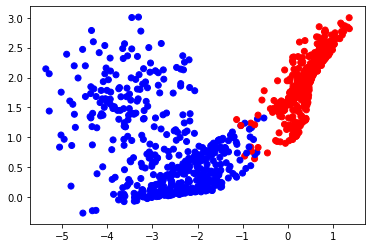

In [167]:
plt.scatter(representations[:,0], representations[:,1], c=colors) # plot representations of data in new space

Note that we have transformed the non-linear problem to a linear problem using the neural networks